In [708]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from astropy.coordinates import SkyCoord
from astropy import units as u
import peakutils
from astropy.time import Time as aTime

import datetime as dt, time

import pandas as pd

In [709]:
def get_file(path):
    #opens and external file and makes it into a list
    fopen = path
    f=open(fopen, 'r+')
    g=list(f)
    g=map(lambda s: s.strip(), g)
    f.close()
    return np.array(list(g))

def splitt(old_list):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split()]
    return new_list

def splitt2(old_list,char):
    #splits the list entries into sublists
    new_list=[]
    for i in old_list:
        new_list+=[i.split(char)]
    return np.array(new_list)

def calendar_array(dates, data):
    i, j = zip(*[d.isocalendar()[1:] for d in dates])
    i = np.array(i) - min(i)
    j = np.array(j) - 1
    ni = max(i) + 1

    calendar = np.nan * np.zeros((ni, 7))
    calendar[i, j] = data
    return i, j, calendar


def calendar_heatmap(ax, dates, data):
    i, j, calendar = calendar_array(dates, data)
    im = ax.imshow(calendar, interpolation='none', cmap='jet')
    label_days(ax, dates, i, j, calendar)
    label_months(ax, dates, i, j, calendar)
    ax.figure.colorbar(im)

    
def label_days(ax, dates, i, j, calendar):
    ni, nj = calendar.shape
    day_of_month = np.nan * np.zeros((ni, 7))
    day_of_month[i, j] = [d.day for d in dates]

    for (i, j), day in np.ndenumerate(day_of_month):
        if np.isfinite(day):
            ax.text(j, i, int(day), ha='center', va='center')

    ax.set(xticks=np.arange(7), 
           xticklabels=['M', 'T', 'W', 'R', 'F', 'S', 'S'])
    ax.xaxis.tick_top()

    
def label_months(ax, dates, i, j, calendar):
    month_labels = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
                             'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    months = np.array([d.month for d in dates])
    uniq_months = sorted(set(months))
    yticks = [i[months == m].mean() for m in uniq_months]
    labels = [month_labels[m - 1] for m in uniq_months]
    ax.set(yticks=yticks)
    ax.set_yticklabels(labels, rotation=90)

In [710]:
ivs_legacy = [s.split('|')[3:-7] for s in open('master2023.txt').readlines()[8:-1] if s[0]!='-']
ivs_intens = [s.split('|')[3:-7] for s in open('master2023-int.txt').readlines()[8:-1] if s[0]!='-']
ivs_master = np.array(ivs_legacy+ivs_intens)

In [711]:
names = ivs_master[:,0].astype(str)
doy = ivs_master[:,1].astype(int)
start = ivs_master[:,2]
st_day = (splitt2(start,':').astype(float)/np.array([24,3600])).sum(1)
dur = ivs_master[:,3]
dur_day = (splitt2(dur,':').astype(float)/np.array([24,3600])).sum(1)
stations = np.array([s.strip(' ').split(' ')[0] for s in ivs_master[:,-1]])
hb = np.array(['Hb' in s for s in stations])
ke = np.array(['Ke' in s for s in stations])
yg = np.array(['Yg' in s for s in stations])
ho = np.array(['Ho' in s for s in stations])
st = [dt.datetime.strptime(f'2023-{doy[i]}T{start[i]}',
                           '%Y-%jT%H:%M') for i in range(len(doy))]

sess = hb.astype(int)+ho.astype(int)+ke.astype(int)+yg.astype(int)
r1   = np.array(['r1' in s for s in names])
r4   = np.array(['r4' in s for s in names])
sess[sess>1]=1
al = np.ones(len(doy)).astype(bool)

In [712]:
yr = 2
day= 365
fday = 96

n = fday*day*yr

year   = np.arange(n).reshape(int(yr*day),fday)/float(fday)
tmplate = np.zeros(n).reshape(int(yr*day),fday)
year_hb = np.zeros(n).reshape(int(yr*day),fday)
year_ho = np.zeros(n).reshape(int(yr*day),fday)
year_ke = np.zeros(n).reshape(int(yr*day),fday)
year_yg = np.zeros(n).reshape(int(yr*day),fday)

year_al = np.zeros(n).reshape(int(yr*day),fday)

year_r1 = np.zeros(n).reshape(int(yr*day),fday)
year_r4 = np.zeros(n).reshape(int(yr*day),fday)


In [713]:
beg_hb,stop_hb = (st_day+doy)[hb], (st_day+doy+dur_day)[hb]
beg_ho,stop_ho = (st_day+doy)[ho], (st_day+doy+dur_day)[ho]
beg_ke,stop_ke = (st_day+doy)[ke], (st_day+doy+dur_day)[ke]
beg_yg,stop_yg = (st_day+doy)[yg], (st_day+doy+dur_day)[yg]

beg_r1,stop_r1 = (st_day+doy)[r1], (st_day+doy+dur_day)[r1]
beg_r4,stop_r4 = (st_day+doy)[r4], (st_day+doy+dur_day)[r4]

beg_al,stop_al = (st_day+doy)[~(~yg*~ke*~ho)], (st_day+doy+dur_day)[~(~yg*~ke*~ho)]

In [714]:
for i in range(len(beg_hb)):
    year_hb[np.where((year>beg_hb[i])*(year<stop_hb[i]))] = 1
    
for i in range(len(beg_ho)):
    year_ho[np.where((year>beg_ho[i])*(year<stop_ho[i]))] = 1
    
for i in range(len(beg_ke)):
    year_ke[np.where((year>beg_ke[i])*(year<stop_ke[i]))] = 1    

for i in range(len(beg_yg)):
    year_yg[np.where((year>beg_yg[i])*(year<stop_yg[i]))] = 1
    
for i in range(len(beg_al)):
    year_al[np.where((year>beg_al[i])*(year<stop_al[i]))] = 1
    
for i in range(len(beg_r1)):
    year_r1[np.where((year>beg_r1[i])*(year<stop_r1[i]))] = 1

for i in range(len(beg_r4)):
    year_r4[np.where((year>beg_r4[i])*(year<stop_r4[i]))] = 1


In [715]:
year_al[163,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [836]:
year_r1_24 = np.copy(tmplate)
year_r4_24 = np.copy(tmplate)
# first monday of 2023 is day 2
# r1s are always 17ut tuesday to 17ut wednesday
# r4s are always 18:30ut wed to 18:30ut thurs

# first dow in 2023 is sunday == 6
dow = np.zeros(int(yr*day))
dow = np.tile(np.roll(np.arange(7),1),53*yr)[:dow.shape[0]]
dow = np.repeat(dow,96).reshape(int(yr*day),fday)
DoW = dow.flatten()

for i in range(52,104):
    year_r1_24[2+i*7,68:] = 1
    year_r1_24[3+i*7,:68] = 1

    year_r4_24[4+i*7,74:] = 1
    year_r4_24[5+i*7,:74] = 1

#del year_al

year_al += year_r1_24 
year_al += year_r4_24 #+ monday 

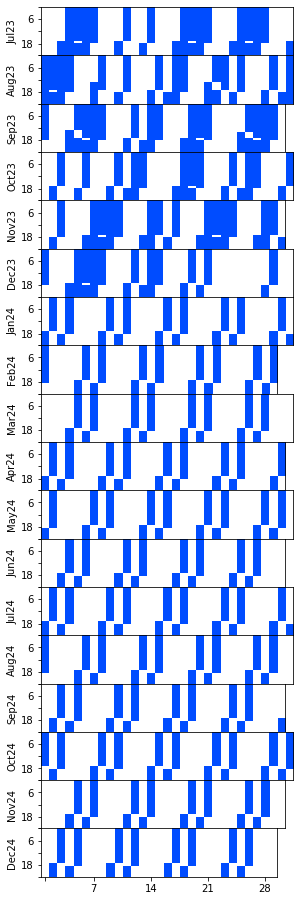

In [717]:
mnth_day = []

plotin = np.copy(year_al)
plotin[year_al==0] = np.nan

for i in range(12):
    mnth_day.append(dt.datetime(2023,i+1,1).timetuple().tm_yday)
for i in range(12):
    mnth_day.append(365+dt.datetime(2024,i+1,1).timetuple().tm_yday)
    
mnth_day.append(365*2)

month_labels = np.array(['Jan23', 'Feb23', 'Mar23', 'Apr23', 'May23', 'Jun23', 'Jul23',
                             'Aug23', 'Sep23', 'Oct23', 'Nov23', 'Dec23',
                         'Jan24', 'Feb24', 'Mar24', 'Apr24', 'May24', 'Jun24', 'Jul24',
                             'Aug24', 'Sep24', 'Oct24', 'Nov24', 'Dec24'])
start = 6 #jul23
stop  = 24 #dec24
fig, ax = plt.subplots(stop-start,1,figsize=(12,16))

for i in range(start,stop):
    k = i - start; j = 0
    col = ax[k+j].imshow(plotin.T[:,(mnth_day[i]):(mnth_day[i+1])],
                 cmap='jet',aspect=0.0625,vmin=0,vmax=5);
    ax[k+j].set_ylabel(month_labels[i])
    #ax[k+j].invert_yaxis()
    ax[k+j].set_yticks([0,24,48,72,95])
    ax[k+j].set_yticklabels(['',6,'',18,''])
    #ax[i].hlines(np.arange(0.5, 96, 24), 0, 365, color='black', linewidth=1)
    
    #if i!=stop-1: ax[k+j].set_xticks([])
    #else: 
    ax[k+j].set_xticks([0,6,13,20,27])
    ax[k+j].set_xticklabels(['',7,14,21,28])


for AX in ax.flatten():
    AX.set_anchor('W')
    
fig.subplots_adjust(hspace=0)
#fig.savefig('/Users/Lucas/SpiralsSchedules/year3schedules/ivs_r1r4.pdf')

In [959]:
time = year.flatten()
ivs  = year_al.flatten()

day

24.0

In [1015]:
startstop = (np.where(np.roll(ivs,+1) != ivs)[0]-1)+1
start = startstop[0::2] # index of start
stop  = startstop[1::2] # index of stop
dur = (stop - start)/4

#format
#|IVS-R1      |20230103|r11084      |  3|17:00|24:00|AgHbHtIsKeKkKvMaNsOnWzYg -Ny                          |NASA|BONN|20230124| XA |NASA|  20|

for i in range(start.shape[0]):
    if DoW[start[i]] == 1: exp = 'r1'; sked='NASA'; corr='BONN'
    elif DoW[start[i]] == 3: exp = 'r4'; sked='UNSO'; corr='WASH'
    else: exp = ' '; corr = '    '; sked = '    '
    doy = np.floor(time[start[i]])%365
    yr  = time[start[i]]//365 #+ 2023
    mnt = np.where(time[start[i]]>mnth_day)[0][-1]
    hr = time[start[i]]%1*24.0//1
    mn = time[start[i]]%1*24.0%1*60
    day = np.floor(time[start[i]] - mnth_day[np.where(time[start[i]]>mnth_day)[0][-1]]) + 1
    if mn>55: hr,mn = hr+1, 0
    print(f'|IVS-{exp:2s}     |{yr+2023:4.0f}{mnt+1-(yr)*12:02.0f}{day:02.0f}|{exp:2s}    |{doy:3.0f}|{hr:02.0f}:{mn:02.0f}|24:00|HbKeYgHo? |{sked:4s}|{corr:4s}|')

|IVS-       |20230103|      |  3|17:15|24:00|HbKeYgHo? |    |    |
|IVS-r4     |20230104|r4    |  4|18:15|24:00|HbKeYgHo? |UNSO|WASH|
|IVS-r1     |20230109|r1    |  9|17:15|24:00|HbKeYgHo? |NASA|BONN|
|IVS-       |20230110|      | 10|17:15|24:00|HbKeYgHo? |    |    |
|IVS-r4     |20230111|r4    | 11|18:15|24:00|HbKeYgHo? |UNSO|WASH|
|IVS-       |20230112|      | 12|18:15|24:00|HbKeYgHo? |    |    |
|IVS-r1     |20230116|r1    | 16|17:15|24:00|HbKeYgHo? |NASA|BONN|
|IVS-       |20230117|      | 17|17:15|24:00|HbKeYgHo? |    |    |
|IVS-r4     |20230118|r4    | 18|18:15|24:00|HbKeYgHo? |UNSO|WASH|
|IVS-       |20230119|      | 19|18:15|24:00|HbKeYgHo? |    |    |
|IVS-r1     |20230123|r1    | 23|17:15|24:00|HbKeYgHo? |NASA|BONN|
|IVS-       |20230124|      | 24|17:15|24:00|HbKeYgHo? |    |    |
|IVS-r4     |20230125|r4    | 25|18:15|24:00|HbKeYgHo? |UNSO|WASH|
|IVS-       |20230126|      | 26|18:15|24:00|HbKeYgHo? |    |    |
|IVS-       |20230127|      | 27|19:15|24:00|HbKeYgHo? |    | 

In [210]:
#G291.274-0.709   s14   11h11m53.35s  -61d18m23.7s  |Jun  7|Dec  6|Feb 27|Aug 27| 1.0|
#G299.772-0.005   s15   12h23m48.97s  -62d42m25.3s  |Jun 27|Dec 26|Mar 15|Sep 12| 1.0|
#G318.948-0.196   s16   15h00m55.40s  -58d58m52.1s  |Aug  7|Feb  6|Apr 22|Oct 19| 1.4|
#G326.475+0.703   s17   15h43m16.64s  -54d07m14.6s  |Aug 17|Feb 17|May  1|Oct 29| 1.6|

#G328.237-0.547   s18   15h57m58.28s  -53d59m22.7s  |Aug 21|Feb 21|      |      | 1.7|
#G329.029-0.205   s19   16h00m31.80s  -53d12m49.6s  |Aug 22|Feb 21|      |      | 1.7|
#G332.295+2.280   s20   16h05m41.72s  -49d11m30.3s  |Aug 23|Feb 23|      |      | 1.9|
#G337.920-0.456   s21   16h41m06.05s  -47d07m02.5s  |Aug 31|Mar  3|      |      | 2.3|
#G345.010+1.792   s22   16h56m47.58s  -40d14m25.8s  |Sep  4|Mar  7|      |      | 3.1|
#G348.550-0.979   s23   17h19m20.41s  -39d03m51.6s  |Sep  9|Mar 12|      |      | 3.5|
#G352.630-1.067   s24   17h31m13.91s  -35d44m08.7s  |Sep 12|Mar 15|      |      | 4.5|

In [960]:
yr = 2
day= 365
fday = 96

n = fday*day*yr

utc_2023 = aTime(dt.datetime(2023,1,1,0,0,0),location=(133.6763,-32.1260))
#utc_2024 = aTime(dt.datetime(2024,1,1,0,0,0),location=(133.6763,-32.1260))

dst_day = 24*60/365.25
dst_hr  = dst_day/24.
dst_qhr = dst_hr/4.

# ceduna sidereal time at 1st day/hour/min/sec of year
sid_2023 = utc_2023.sidereal_time('mean').value
#sid_2024 = utc_2024.sidereal_time('mean').value

In [961]:
sid_year_ced = (np.arange(n)*(dst_qhr+15))/60.
sid_ced = (sid_year_ced+sid_2023).reshape(int(yr*day),fday)
# removing day offsets
for i in range(day*yr):
    sid_ced[i,:] = sid_ced[i,:]-24.*i

# unwrapping days
sid_ced[np.where(sid_ced > 24)]+=-24
sid_ced[np.where(sid_ced > 24)]+=-24

sid_ced[np.where(sid_ced > 24)]+=-24
sid_ced[np.where(sid_ced > 24)]+=-24

In [1045]:
mas_up = np.copy(tmplate)

# masers = [
#  [13+50/60.,  [7, 20], [ 1, 19]],   # s14
#  [11+11/60.,  [6,  7], [12,  6]],   # s15
#  [12+23/60.,  [6, 27], [12, 26]],   # s16
#  [15+ 0/60.,  [8,  7], [ 2,  6]],   # s17
#  [15+43/60.,  [8, 17], [ 2, 17]],   # s18
#  [15+57/60.,  [8, 21], [ 2, 21]],   # s19
#  [16+ 0/60.,  [8, 22], [ 2, 21]],   # s20
#  [16+ 5/60.,  [8, 23], [ 2, 23]],   # s21
#  [16+41/60.,  [8, 31], [ 3,  3]],   # s22
#  [16+56/60.,  [9,  4], [ 3,  7]],   # s23
#  [17+19/60.,  [9,  9], [ 3, 12]],   # s24
#  [17+31/60.,  [9, 12], [ 3, 15]]]   # s25


masers = [
[10+48/60., [ 6, 1], [11,30],'g287'],  #s3
#[11+11/60., [ 6, 8], [12, 7],'g291'],  #s14
#[12+23/60., [ 6,28], [12,27],'g299'],  #s15
#[13+11/60., [ 7, 9], [ 1, 8],'g305'],       
#[13+50/60., [ 7,21], [ 1,20],'g309'],  #s4
#[15+29/60., [ 8,14], [ 2,14],'g323'],
#[16+ 3/60., [ 8,23], [ 2,23],'g329'],
#[16+12/60., [ 8,24], [ 2,24],'g331'],
#[16+41/60., [ 8,26], [ 2,26],'g337'],
#[16+40/60., [ 9, 1], [ 3, 4],'g338']
]

#print('{:<6s} {:<6s} {:<6s} {:<5s} {:<3s}'.format('maser','year','doy','start','dur'))

#print('-------------------------------')

for i in range(len(masers)):
    w = 0
    for j in range(3):
        if   j==0: peak = np.array([0])
        elif j==1: peak = np.array([0])+(w)*365
        elif j==2: j=0 ; peak = np.array([0])+(w+1)*365
        for k in peak:
            ra  = masers[i][0]
            mnt = int(masers[i][j+1][0])
            day = int(masers[i][j+1][1])
            pday = mnth_day[mnt-1]+day+k
            if pday<=220: 
                w = 0
                #continue
                #pday = pday+365
                #
            #print(pday)
            #if pday>=(2*365): 
            #    continue 
            #print('{:<6s} {:<6.0f} {:<6.0f} {:>5.2f} {:>3.0f}'.format(masers[i][-1],
            #       np.floor(2023+pday/365),np.round(pday%365,2),
            #       (np.arange(0,24,0.25)[abs(sid_ced[pday%365,:]-ra)<.25]-5).min(),10))
            
            mas_up[pday,(abs(sid_ced[pday%365,:]-ra)<5)]+=1
        #print('-')
    #print('-------------------------------')

    

In [1047]:
m[32150:32240]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [1048]:
m = mas_up.flatten()
start = np.where(np.diff(m)>0)[0]
#start = startstop[0::2] # index of start
#stop  = startstop[1::2] # index of stop
#dur = (stop - start)/4.0

#format
#|IVS-R1      |20230103|r11084      |  3|17:00|24:00|AgHbHtIsKeKkKvMaNsOnWzYg -Ny                          |NASA|BONN|20230124| XA |NASA|  20|

for i in range(start.shape[0]):
    #if DoW[start[i]] == 1: exp = 'r1'; sked='NASA'; corr='BONN'
    #elif DoW[start[i]] == 3: exp = 'r4'; sked='UNSO'; corr='WASH'
    #else: exp = ' '; corr = '    '; sked = '    '
    exp = 's?'
    sked = 'UTAS'
    corr = 'UTAS'
    doy = np.floor(time[start[i]])%365
    yr  = time[start[i]]//365 #+ 2023
    mnt = np.where(time[start[i]]>mnth_day)[0][-1]
    hr = time[start[i]]%1*24.0//1
    mn = time[start[i]]%1*24.0%1*60
    day = np.floor(time[start[i]] - mnth_day[np.where(time[start[i]]>mnth_day)[0][-1]])
    if mn>55: hr,mn = hr+1, 0
    print(f'|SPIRALS     |{yr+2023:4.0f}{mnt+1-(yr)*12:02.0f}{day:02.0f}|{exp:2s}    |{doy:3.0f}|{hr:02.0f}:{mn:02.0f}|10:00|CdHoKeYgWa |{sked:4s}|{corr:4s}|')

|SPIRALS     |20230601|s?    |153|04:00|10:00|CdHoKeYgWa |UTAS|UTAS|
|SPIRALS     |20231129|s?    |334|23:45|10:00|CdHoKeYgWa |UTAS|UTAS|
|SPIRALS     |20231200|s?    |335|16:00|10:00|CdHoKeYgWa |UTAS|UTAS|
|SPIRALS     |20240600|s?    |153|04:00|10:00|CdHoKeYgWa |UTAS|UTAS|


In [1049]:
plotin =  np.copy(tmplate)
plotin[np.where(year_al==1)] = 1
plotin[np.where(mas_up!=0)] = 2
plotin[np.where((year_al==1)*(mas_up!=0))] = 3
plotin[plotin==0] = np.nan

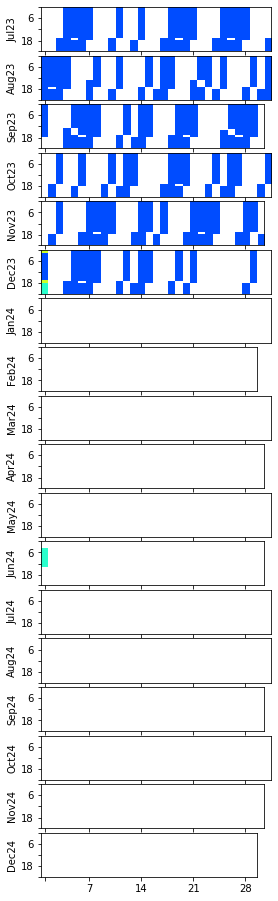

In [1050]:

#mas_up + year_al #+  mas_up #+ monday

start = 6 #jul23
stop  = 24 #dec24
fig, ax = plt.subplots(stop-start,1,figsize=(12,16))

for i in range(start,stop):
    k = i - start; j = 0
    col = ax[k+j].imshow(plotin.T[:,(mnth_day[i]):(mnth_day[i+1])],
                 cmap='jet',aspect=0.0625,vmin=0,vmax=5);
    ax[k+j].set_ylabel(month_labels[i])
    #ax[k+j].invert_yaxis()
    ax[k+j].set_yticks([0,24,48,72,95])
    ax[k+j].set_yticklabels(['',6,'',18,''])
    #ax[i].hlines(np.arange(0.5, 96, 24), 0, 365, color='black', linewidth=1)
    
    #if i!=stop-1: ax[k+j].set_xticks([])
    #else: 
    ax[k+j].set_xticks([0,6,13,20,27])
    ax[k+j].set_xticklabels(['',7,14,21,28])


for AX in ax.flatten():
    AX.set_anchor('W')
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(hspace=0.1,wspace=0.1)
#fig.savefig('/Users/Lucas/masers_up_ivs.pdf',bbox_inches='tight')

In [691]:
hour_angle = sid_ced.flatten() - masers[0][0]
t = year.flatten()
maser_transit = abs(hour_angle) < 0.125
maser_rise = np.roll(maser_transit,-20) #5 hours before 
maser_sets = np.roll(maser_transit, 20) #5 hours after
rise_time  = year.flatten()[maser_rise]

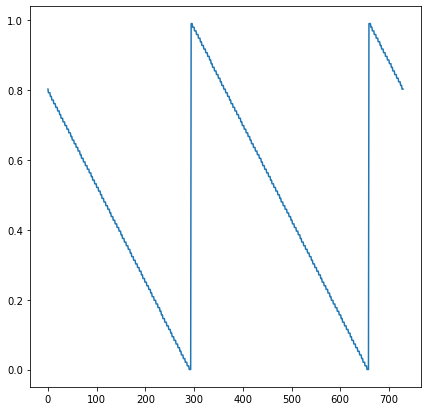

In [673]:
fig, ax = plt.subplots(1,figsize=(7,7))
#ax.plot(t,hour_angle,'.')
#ax.plot(t[maser_up],hour_angle[maser_up],'r.')
ax.plot(t[maser_up]%1)
#ax.set_xlim(0,10)

In [690]:
.shape

(730,)